In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [2]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download=True
)

In [3]:
classes = train_data.classes
print('Labels:')
print(classes)

Labels:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


Shape of sample of train_data: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Class: Ankle boot')

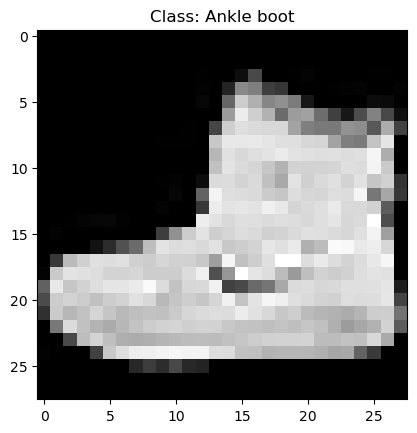

In [4]:
print(train_data, test_data)
print('\n')
image, label = train_data[0]
print(f'Shape of sample of train_data: {image.shape}')
plt.imshow(image.squeeze(), cmap='grey');
plt.title(f'Class: {classes[label]}')

In [5]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [6]:
# device agnostic code
device = None
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

device

'mps'

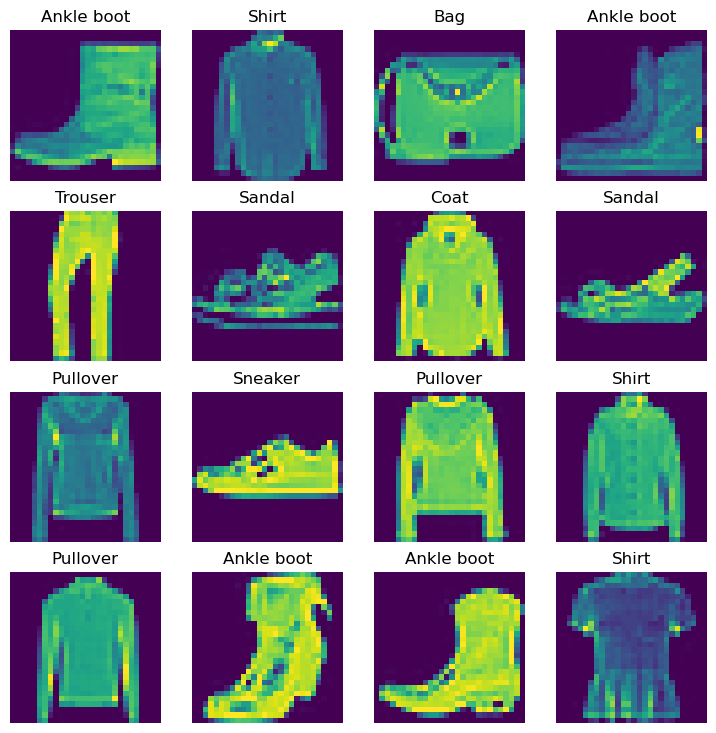

In [7]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    idx = torch.randint(low=0, high=len(train_data.data), size=(1,)).item()
    image, label = train_data[idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze())
    plt.title(classes[label])
    plt.axis(False)

In [8]:
BATCH_SIZE=32

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=True)

print(f'Size of Train Dataloader: {len(train_dataloader)}, with {BATCH_SIZE} samples each')
print(f'Size of Test Dataloader: {len(test_dataloader)}, with {BATCH_SIZE} samples each')

Size of Train Dataloader: 1875, with 32 samples each
Size of Test Dataloader: 313, with 32 samples each


In [9]:
images_batch, labels_batch = next(iter(train_dataloader))
images_batch.shape, labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Bag')

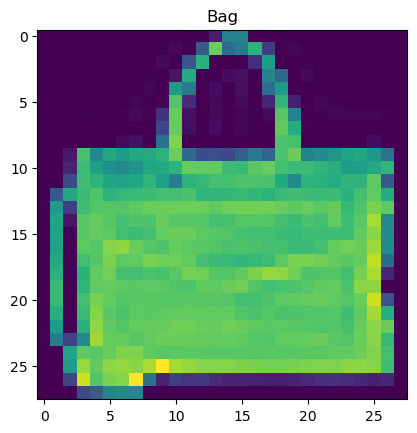

In [10]:
idx = torch.randint(low=0, high=len(images_batch), size=(1,)).item()
image, label = images_batch[idx], labels_batch[idx]
print(f'Image size: {image.shape}')
plt.imshow(image.squeeze());
plt.title(classes[label])

In [11]:
# Baseline Model

flatten_model = nn.Flatten()
print(f'Previous shape: {image.shape}, flattened shape: {flatten_model(image).shape}')

Previous shape: torch.Size([1, 28, 28]), flattened shape: torch.Size([1, 784])


In [12]:
class modelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [38]:
model0 = modelV0(input_shape=784, hidden_units=10, output_shape=len(classes))
model0, next(model0.parameters()).device

(modelV0(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=10, bias=True)
     (2): Linear(in_features=10, out_features=10, bias=True)
   )
 ),
 device(type='cpu'))

In [39]:
import torchmetrics

In [40]:
accuracy_fn = torchmetrics.Accuracy(num_classes=len(classes))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [41]:
# timing function
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device=None):
    total_time = end - start
    print(f'Train time on {device}: {total_time: .3f} seconds')
    return total_time

In [42]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_start_time_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    # Train:
    print(f'Epoch: {epoch}\n------')
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model0.train()
        output = model0(X)
        loss = loss_fn(output, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f'Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples')

    train_loss /= len(train_dataloader)

    # Test:
    test_loss, test_acc = 0, 0
    model0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f'\nTrain Loss: {train_loss:.5f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc*100:.2f}')

train_end_time_cpu = timer()
total_train_time_model0 = print_train_time(start=train_start_time_cpu,
                                           end=train_end_time_cpu,
                                           device=str(next(model0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.59176 | Test Loss: 0.50948 | Test Accuracy: 82.21
Epoch: 1
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.47375 | Test Loss: 0.52864 | Test Accuracy: 81.62
Epoch: 2
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.45340 | Test Loss: 0.51284 | Test Accuracy: 82.81
Train time on cpu:  12.633 seconds
